## Libraries

In [143]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 


import warnings

## Data Cleaning

In [133]:
file_path = "./datasets/nhanes_hba1c_merged.csv"
df = pd.read_csv(file_path)

In [134]:
print("Row Number:", df.shape[0])
print("Rows with HbA1c (LBXGH):", df["LBXGH"].notna().sum())
print("Rows with age + HbA1c:", df[["RIDAGEYR", "LBXGH"]].dropna().shape[0])

duplicate_seqn = df["SEQN"].duplicated().sum()
print("Duplicate SEQN entries:", duplicate_seqn)

empty_cols = [col for col in df.columns if df[col].isnull().all()]
print(f"Empty Columns: {empty_cols}")
df = df.drop(empty_cols, axis=1)

nan_count = df.isnull().sum()
na_percentage = (nan_count / 9254)*100
na_high = (na_percentage > 40).sum()
print(f"Number of Columns with greater than 40% of values being NA: {na_high}")
df = df.loc[:, df.isna().mean() < 0.4]

missing_lbxgh = df['LBXGH'].isna().sum()
print(f"Rows with missing LBXGH (HbA1c): {missing_lbxgh}")
df = df.dropna(subset=['LBXGH'])

irrelevant_cols = [
    'SDDSRVYR', 'RIDSTATR',
    'SIALANG', 'SIAPROXY', 'SIAINTRP',
    'FIALANG', 'FIAPROXY', 'FIAINTRP',
    'MIALANG', 'MIAPROXY', 'MIAINTRP',
    'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ',
    'SDMVPSU', 'SDMVSTRA',
    'BMDSTATS', 'DIQ010', 'DIQ160', 'DIQ170'	
    ,'DIQ172'	
    ,'DIQ180', 'DIQ050', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA'
]


print(f"Irrelevant Col Count: {len(irrelevant_cols)}")
df = df.drop(irrelevant_cols, axis=1)

print(f"Final Data Shape: {df.shape}")

Row Number: 9254
Rows with HbA1c (LBXGH): 6045
Rows with age + HbA1c: 6045
Duplicate SEQN entries: 0
Empty Columns: ['BMIHEAD']
Number of Columns with greater than 40% of values being NA: 65
Rows with missing LBXGH (HbA1c): 3209
Irrelevant Col Count: 28
Final Data Shape: (6045, 28)


In [136]:
nhanes_variable_dict = {
    "SEQN": "Respondent sequence number (unique identifier)",
    "RIAGENDR": "Gender of respondent (1=Male, 2=Female)",
    "RIDAGEYR": "Age in years at screening",
    "RIDRETH1": "Race/ethnicity (5-level: Mexican Am., Other Hispanic, Non-Hispanic White, Non-Hispanic Black, Other)",
    "RIDRETH3": "Race/ethnicity (6-level: includes multi-racial)",
    "RIDEXMON": "Month of exam (1=November–April, 2=May–October)",
    "DMQMILIZ": "Served active duty in U.S. Armed Forces (1=Yes, 2=No)",
    "DMDBORN4": "Country of birth (1=USA, 2=Other, 3=Don't know/refused)",
    "DMDCITZN": "U.S. citizenship status (1=Citizen by birth, 2=Citizen by naturalization, 3=Non-citizen)",
    "DMDEDUC2": "Education level for adults 20+ (1=<9th grade to 5=College graduate)",
    "DMDMARTL": "Marital status (1=Married, 2=Widowed, ..., 6=Never married)",
    "DMDHHSIZ": "Total number of people in household",
    "DMDFMSIZ": "Total number of family members in household",
    "DMDHHSZA": "Number of children aged 0–5 in household",
    "DMDHHSZB": "Number of children aged 6–17 in household",
    "DMDHHSZE": "Number of adults aged 60+ in household",
    "INDHHIN2": "Household income (categorical levels)",
    "INDFMIN2": "Family income (categorical levels)",
    "INDFMPIR": "Family income to poverty ratio (continuous)",
    "BMXWT": "Weight in kilograms",
    "BMXHT": "Standing height in centimeters",
    "BMXBMI": "Body Mass Index (kg/m²)",
    "BMXLEG": "Upper leg length in centimeters",
    "BMXARML": "Upper arm length in centimeters",
    "BMXARMC": "Arm circumference in centimeters",
    "BMXWAIST": "Waist circumference in centimeters",
    "BMXHIP": "Hip circumference in centimeters",
    "LBXGH": "Glycohemoglobin (HbA1c) (% of total hemoglobin)",
}

# Categorical variables (require encoding)
categorical_vars = [
    "RIAGENDR",     # Gender
    "RIDRETH1",     # Race/ethnicity (5-level)
    "RIDRETH3",     # Race/ethnicity (6-level)
    "RIDEXMON",     # Month of exam
    "DMQMILIZ",     # Military service
    "DMDBORN4",     # Country of birth
    "DMDCITZN",     # Citizenship status
    "DMDEDUC2",     # Education level
    "DMDMARTL",     # Marital status
    "INDHHIN2",     # Household income
    "INDFMIN2"      # Family income
]

# Numeric variables (can be used directly)
numeric_vars = [
    "RIDAGEYR",     # Age
    "DMDHHSIZ",     # Household size
    "DMDFMSIZ",     # Family size
    "DMDHHSZA",     # Children 0–5
    "DMDHHSZB",     # Children 6–17
    "DMDHHSZE",     # Adults 60+
    "INDFMPIR",     # Income to poverty ratio
    "BMXWT",        # Weight
    "BMXHT",        # Height
    "BMXBMI",       # BMI
    "BMXLEG",       # Leg length
    "BMXARML",      # Arm length
    "BMXARMC",      # Arm circumference
    "BMXWAIST",     # Waist circumference
    "BMXHIP",       # Hip circumference
    "LBXGH"         # HbA1c (target)
]

# Not used for modeling (identifier)
id_var = ["SEQN"]

### Categorical Encoding

In [137]:
df["RIAGENDR"] = df["RIAGENDR"].map({1: 1, 2: 0})
df["DMQMILIZ"] = df["DMQMILIZ"].map({1: 1, 2: 0})

df = pd.get_dummies(df, columns=["RIDRETH1", "RIDRETH3", "RIDEXMON", "DMDBORN4", "DMDCITZN", "DMDMARTL"], drop_first=True, dtype='float')

edu_map = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 7: None, 9: None}
inc_map = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 77: None, 99: None}

df["DMDEDUC2"] = df["DMDEDUC2"].map(edu_map)
df["INDHHIN2"] = df["INDHHIN2"].map(inc_map)
df["INDFMIN2"] = df["INDFMIN2"].map(inc_map)

## Feature Analysis

In [138]:
df[numeric_vars].describe()

,RIDAGEYR,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,INDFMPIR,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXHIP,LBXGH
count,6045.000000,6045.000000,6045.000000,6.045000e+03,6.045000e+03,6.045000e+03,5.279000e+03,5960.000000,5959.000000,5951.00000,5724.000000,5809.000000,5807.000000,5747.000000,5760.000000,6045.000000
mean,45.428619,3.353350,3.210918,2.486352e-01,7.010753e-01,6.302730e-01,2.481934e+00,80.302802,166.057124,28.99138,39.190811,37.168015,32.712881,97.786027,105.393681,5.769562
std,21.056251,1.686127,1.729474,5.960522e-01,9.955928e-01,8.095088e-01,1.601646e+00,23.190126,10.059778,7.51544,3.829499,2.854326,5.519039,18.060477,14.826538,1.037838
min,12.000000,1.000000,1.000000,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,30.300000,134.000000,13.20000,26.000000,27.500000,17.600000,56.400000,66.600000,3.800000
25%,26.000000,2.000000,2.000000,5.397605e-79,5.397605e-79,5.397605e-79,1.140000e+00,63.900000,158.600000,23.80000,36.500000,35.100000,28.800000,84.800000,95.300000,5.200000
50%,46.000000,3.000000,3.000000,5.397605e-79,5.397605e-79,5.397605e-79,2.030000e+00,76.900000,165.500000,27.90000,39.200000,37.000000,32.400000,96.800000,103.200000,5.500000
75%,63.000000,5.000000,4.000000,5.397605e-79,1.000000e+00,1.000000e+00,3.920000e+00,92.700000,173.300000,32.90000,41.800000,39.000000,36.200000,109.200000,112.800000,5.900000
max,80.000000,7.000000,7.000000,3.000000e+00,3.000000e+00,3.000000e+00,5.000000e+00,242.600000,197.700000,86.20000,55.000000,49.900000,56.300000,169.500000,179.000000,16.200000


RIDAGEYR    1
DMDHHSIZ    2
DMDFMSIZ    2
DMDHHSZA    1
DMDHHSZB    1
DMDHHSZE    1
INDFMPIR    1
BMXWT       2
BMXHT       1
BMXBMI      3
BMXLEG      1
BMXARML     1
BMXARMC     2
BMXWAIST    2
BMXHIP      2
LBXGH       1
dtype: int64


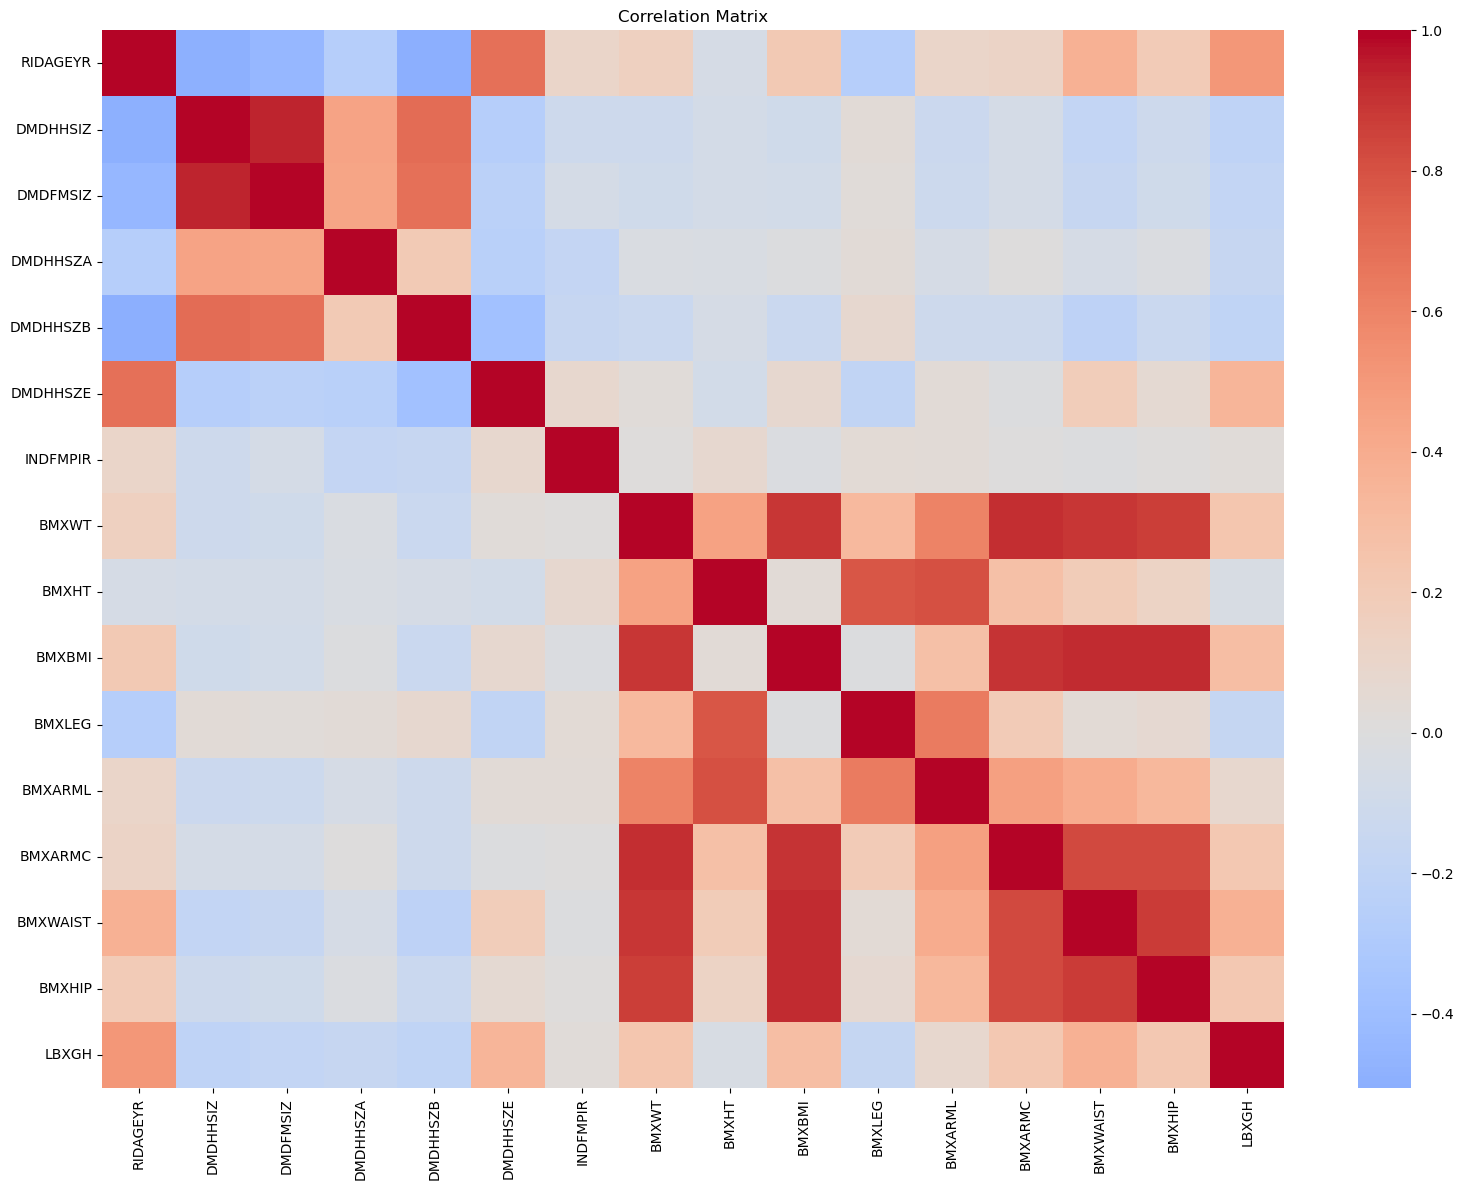

In [139]:
df_corr = df[numeric_vars].drop(columns=["SEQN"], errors="ignore")

corr_matrix = df_corr.corr(method='spearman')
print((corr_matrix > 0.9).sum())

# Visualize
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

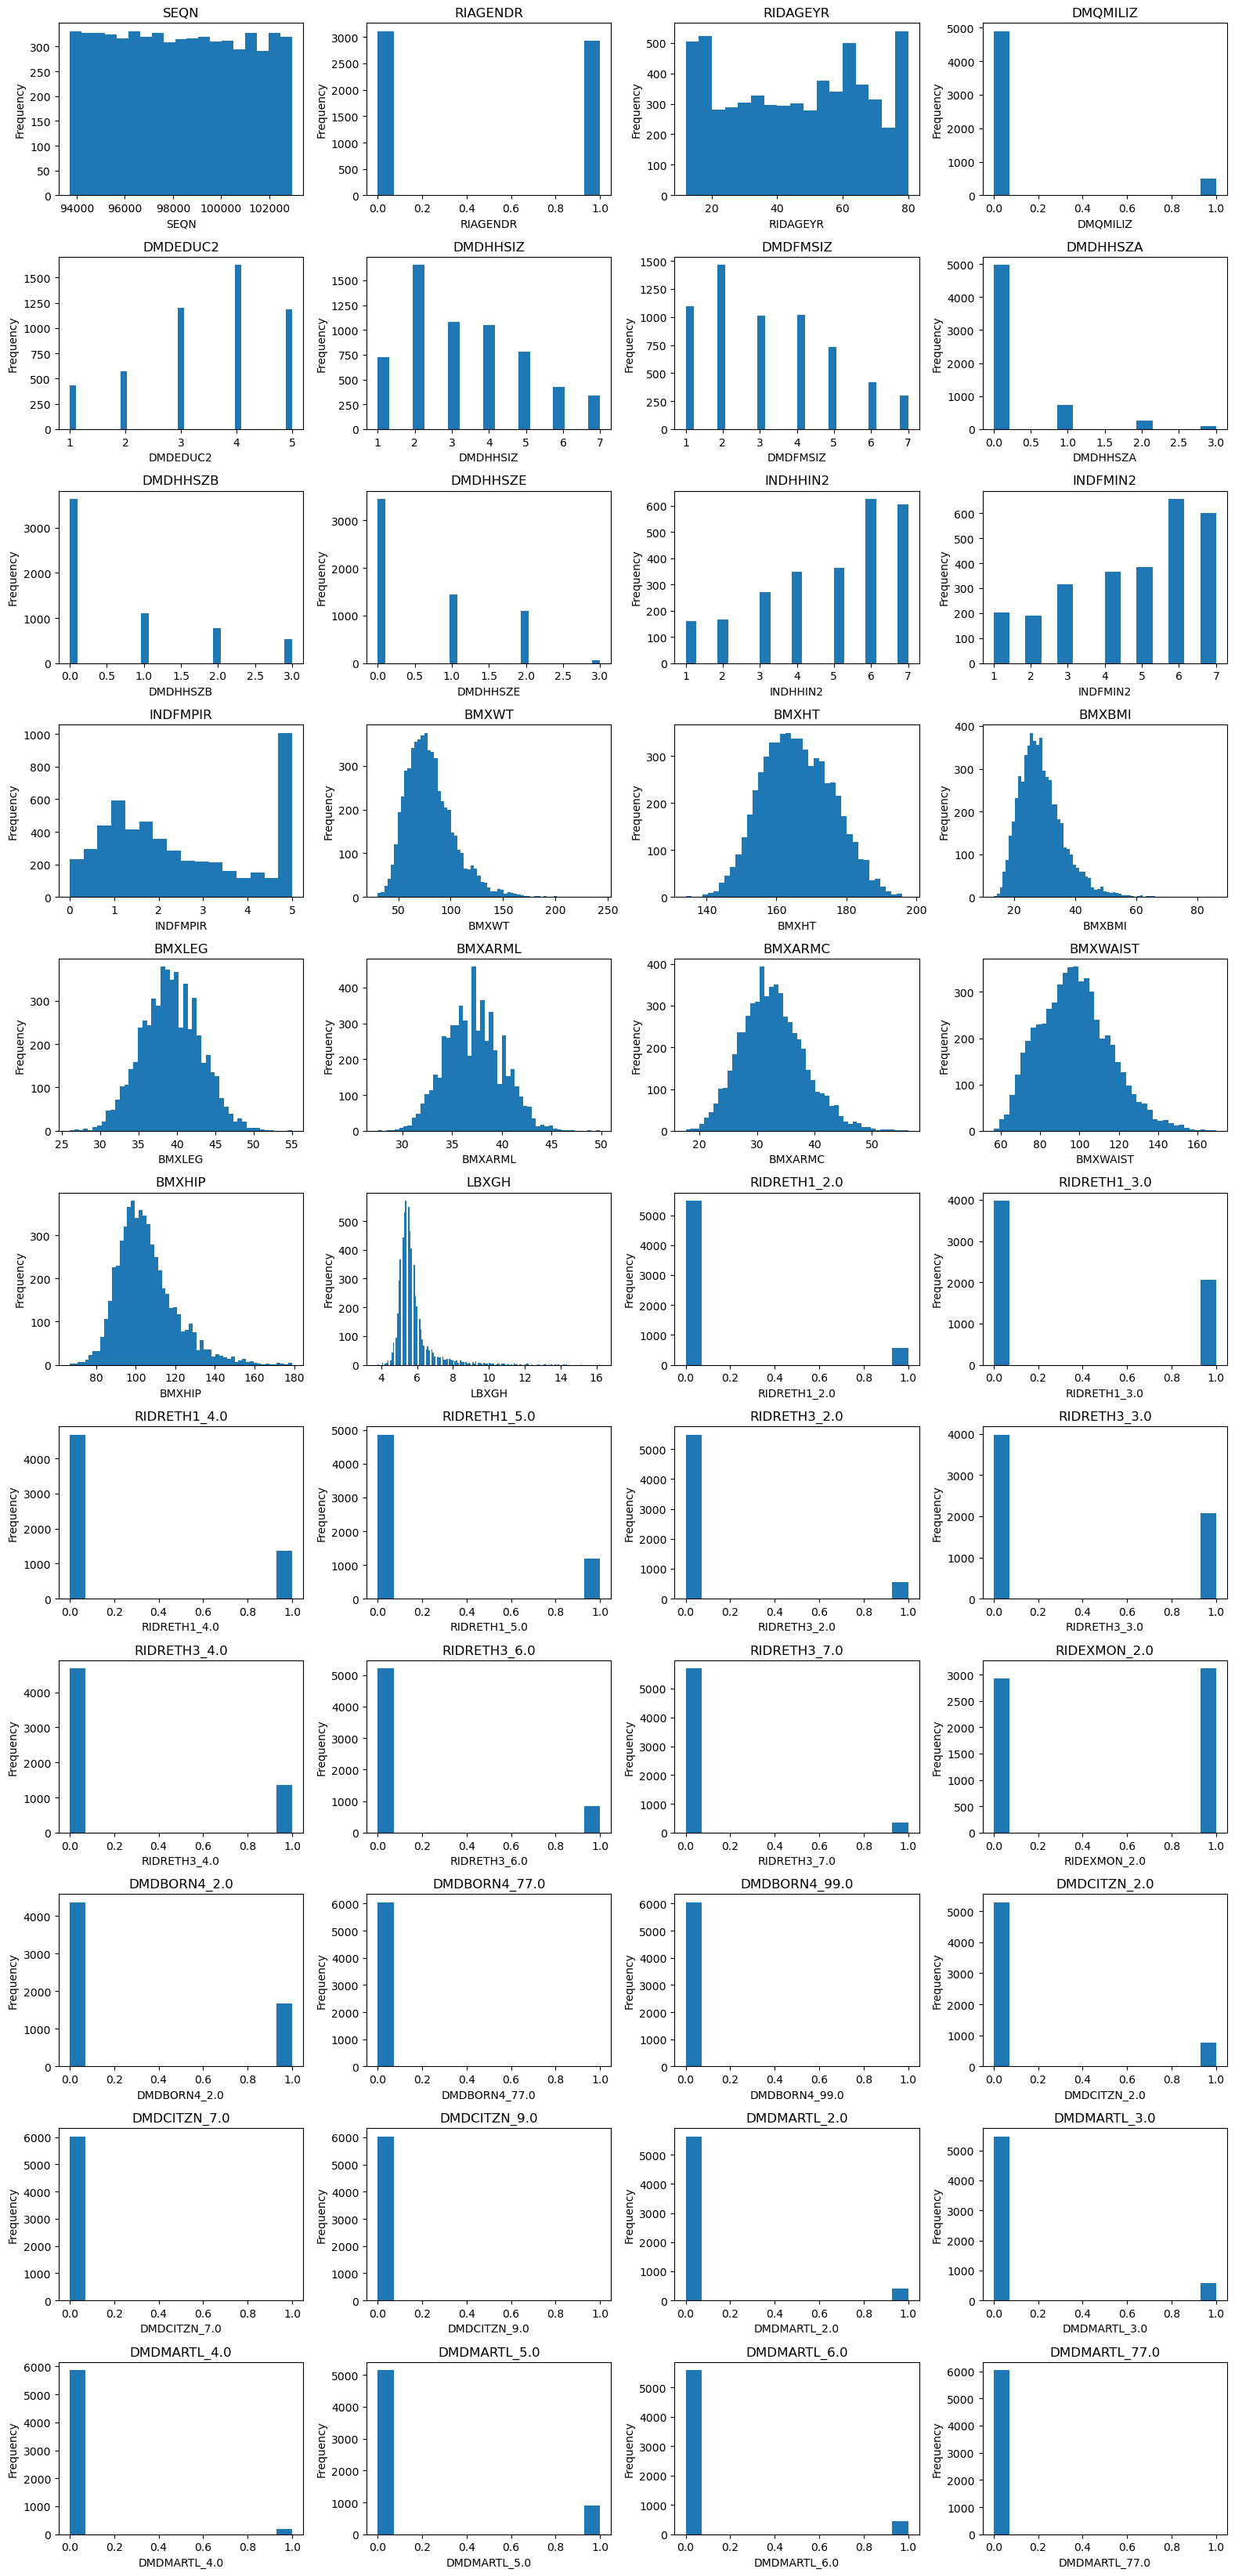

In [145]:
# Define grid size
n_cols = 4  # Number of histograms per row
n_rows = math.ceil(len(df.columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(df.columns):
    axes[i].hist(df[col].dropna(), bins='auto')
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Target Analysis